In [67]:
import numpy as np
from matplotlib import pyplot as plt

import pickle as pkl
from matplotlib import style
import jax.numpy as jnp
from jax import jacfwd, jit,grad
from functools import partial


from Robot import Robot
from virtual_sensor import virtual_sensor
from utils.DynamicFilters import getDynamicFilter
from utils.FIMPathPlanning import FIM_descent_path_planning 
from CircleGenerator import CircleGenerator
from utils.ConcentricPathPlanning import concentric_path_planning
from utils.StraightLinePathPlanning import straight_line_path_planning
from utils.MutualSepPathPlanning import mutual_separation_path_planning

from utils.dLdp import analytic_dLdp,analytic_FIM,analytic_dhdz
from utils.regions import CircleExterior
from tracking_log import logger

style.use('fivethirtyeight')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Plotting Utilities

In [19]:
def plot_trajectory(ax,traj,name,marker,size=50):
    def direction_at(i):
        direction = traj[i+1,:]-traj[i,:]
        return traj[i,0],traj[i,1], direction[0],direction[1]
    
    ax.scatter(traj[:,0],traj[:,1],label=name,marker=marker,s = size)
	


    
def plot_dist_to_source(ax,log):
    src_locs = log['src_locs']['source_1']
    for key,sensor_locs in log['sensor_locs'].items():
        l = np.min([len(sensor_locs),len(src_locs)])
        dist = np.linalg.norm(sensor_locs[:l]-src_locs[:l],axis = 1)
        ax.plot(dist,label = key)
    ax.set_title('Sensor-Source Distance vs Time steps',fontsize=15)
    ax.set_xlabel('Time Steps')
#     ax.legend()
    
def plot_L(ax,log):
    q = log['src_locs']['source_1']
    ps = []
    for key,sensor_locs in log['sensor_locs'].items():
        l = np.min([len(sensor_locs),len(q)])
        ps.append(sensor_locs[:l])
    ps = np.hstack(ps).reshape(-1,3,2)
    Ls = [f_L(q[i,:],ps[i,:]) for i in range(l)]
    ax.plot(np.log(Ls),label = r'$\log(L(p,q))$')
    
    for key,qhat in log['est_locs_log'].items():
        if key in["ekf"]:            
            Lhat = [f_L(qhat[i,:],ps[i,:]) for i in range(l)]
            ax.plot(np.log(Lhat),label = r'$\log(L(p,qhat))$')
      
    ax.legend(loc='lower right')
#     ax.set_title('log(L(ps,q)) vs Time steps',fontsize=15)
    ax.set_ylabel('log loss')

def plot_all(log,main_title,save_file_name):
    fig = plt.figure(dpi=100,figsize=(10,10))
    gs = fig.add_gridspec(2,1)

    
    ax = fig.add_subplot(gs[0,:])
#     rectangle = plt.Rectangle((0,0), 3, 3, alpha=0.3,fc='red',ec="red")
#     ax.add_artist(rectangle)
#     ax.text(0.5,1.5,'Starting Region of the Sensors')
    plot_experiment(ax,log)
    
#     ax = fig.add_subplot(gs[1,:])
#     plot_dist_to_source(ax,log)
    
    
    ax.set_title(main_title,fontsize=20)
    
    fig.tight_layout()

    plt.savefig(save_file_name,bbox_inches='tight')


# animation function. This is called sequentially
def plot_experiment(ax,log):
#     ax.clear()

#     ax.set_xlim((-1,8))
#     ax.set_ylim((-1,7))

    ax.set_aspect('equal',adjustable='box')
           
    
    for key,val in log['src_locs'].items():
        plot_trajectory(ax,val,'Static Source','*',size = 400)

    for key,val in log['sensor_locs'].items():
        plot_trajectory(ax,val,"",'.',size=200)
    

#     ax.legend(loc='right')
#     ax.set_xlabel('x')
#     ax.set_ylabel('y')
    

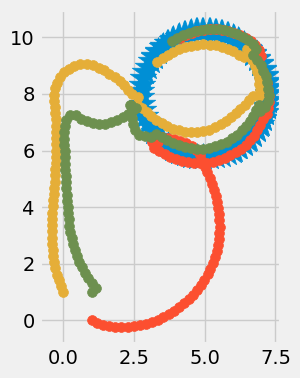

In [20]:
i=0
for (log,name) in zip(logs,loss_funcs.keys()):
    fig = plt.figure(dpi=100)

    if name=='-Tr(FIM)':
        continue
#     plot_all(log.export(),'','{}.png'.format(name))
    ax = plt.gca()
    plot_experiment(ax,log.export())
    i+=1
    
    fig.tight_layout()
    fig.savefig('{}.png'.format(name))
    plt.show()



In [3]:
def random_initial_poses(n_sensors,xmin,xmax,ymin,ymax):
    sensor_poses = np.zeros((n_sensors,2))
    sensor_poses[:,0]= xmin + np.random.rand(n_sensors)*(xmax-xmin)
    sensor_poses[:,1]= ymin + np.random.rand(n_sensors)*(ymax-ymin)
    return sensor_poses

## Main Loop

In [71]:
def main(n_sensors,std, N,fplan,C1,C0,k,b,no_estimation=False,L_func=None,rand_locs = True):
    
    # Set up mobile sensors and sources
    src_locs = [[6.,6]]
    src_names = ["source_{}".format(i+1) for i in range(len(src_locs))]
    source = [Robot(loc,name) for loc,name in zip(src_locs,src_names)]

    if rand_locs:
        initial_locs = random_initial_poses(n_sensors,xmin=0,xmax=3,ymin=0,ymax=3)
    else:
        initial_locs = np.array([[1.,0],[0,1],[1,1]])
    sensor_names = ["mobile_sensor_{}".format(i+1) for i in range(len(initial_locs))]
    mobile_sensors = [Robot(loc,name) for loc,name in zip(initial_locs,sensor_names)]

    ## Set up virtual sensors
   
    vs = virtual_sensor(C1,C0,b,k,std)
    
    # Set up location estimator
    n_src = len(source)
    
    C1s=C1*np.ones(n_sensors)
    C0s = C0*np.ones(n_sensors)
    ks = k * np.ones(n_sensors)
    bs = b*np.ones(n_sensors)
    initial_guess = np.array([4.,2.])
    xlim = (-np.inf,np.inf)
    ylim = (-np.inf,np.inf)

    estimator = getDynamicFilter(len(mobile_sensors),len(source),C1s,C0s,ks,bs,initial_guess,filterType="ekf",xlim=xlim,ylim=ylim)
    estimator_name = 'ekf'
    
    # Set up source motion planner
    origin = np.array([5,8])
    splan = CircleGenerator(origin=origin,radius=np.linalg.norm(origin-src_locs[0]),dtheta=0.025)
    # Set up data logger
    log = logger(sensor_names,src_names)
    log.est_locs_log['Estimation']=[]
    
    
    # Main Loop

    for _ in range(N):


        # Record
        for s in source:
            log.src_locs[s.name].append(s.loc)

        for m in mobile_sensors:
            log.sensor_locs[m.name].append(m.loc)

        # Measure
        ps = np.array([r.loc for r in mobile_sensors])
        qs = np.array([s.loc for s in source])
        y = vs.measurement(qs,ps)
        
        if no_estimation:
            qhat = qs
        else:
       # Estimate
            qhat = estimator.update_and_estimate_loc(ps,y)
            log.est_locs_log['Estimation'].append(qhat)
        
        # Plan
        if not L_func is None and type(L_func)==tr_filter_covariance:
            L_func.P=estimator.filter.P
            L_func.R = estimator.filter.R
        waypoints = fplan(qhat,ps,y)
        # Move
        for i in range(n_sensors):
            mobile_sensors[i].update_loc(waypoints[0][i])
        for i in range(len(source)):
            wp = splan.get_waypoints(source[i].loc)
            source[i].update_loc(wp[1])
    return log


## Run experiments and save data

In [5]:
def get_dists_to_src(log):
    src_locs = log['src_locs']['source_1']
    dists = []
    for key,sensor_locs in log['sensor_locs'].items():
        l = np.min([len(sensor_locs),len(src_locs)])
        dists.append(np.linalg.norm(sensor_locs[:l]-src_locs[:l],axis = 1))
    return np.array(dists)

In [6]:
def get_estimation_error(log):
    src_locs = log['src_locs']['source_1']
    dists = []
    qhat = log['est_locs_log']['Estimation']
    l = np.min([len(qhat),len(src_locs)])
    return np.linalg.norm(qhat[:l]-src_locs[:l],axis = 1)

In [7]:
class tr_filter_covariance:
    def __init__(self,dhdx):
        self.P = 1
        self.R= 1
        self.dhdx = dhdx
    def __call__(self,q,ps):
        C = self.dhdx(q,ps)
        return jnp.trace(jnp.linalg.inv(C.T.dot(jnp.linalg.inv(self.R)).dot(C)+jnp.linalg.inv(self.P)))

In [12]:
def get_loss_funcs(n_sensors,C1,C0,k,b):
    # Set up parameters
   
    C1s=C1*np.ones(n_sensors)
    C0s = C0*np.ones(n_sensors)
    ks = k * np.ones(n_sensors)
    bs = b*np.ones(n_sensors)


    F = partial(analytic_FIM,C1s=C1s,C0s=C0s,ks=ks,bs=bs)

    # 1. Our loss function Tr(FIM^-1)
    def tr_FIM_inv(q,ps):
        return jnp.trace(jnp.linalg.inv(F(q,ps)))
    # 2. -Tr(FIM). Gradient descent on this function is equivalent to go at the estimated source direction.
    def neg_tr_FIM(q,ps):
        return -jnp.trace(F(q,ps))
    # 3. -log(det(FIM))
    def neg_log_det_FIM(q,ps):
        return -jnp.log(jnp.linalg.det(F(q,ps)))
    # 4. The largest eigenvalue of FIM^{-1}, or equivalently its L2 induced norm since it is P.   
    def max_FIM_inv_eig(q,ps):
          return jnp.linalg.norm(jnp.linalg.inv(F(q,ps)),ord=2)


    dhdx = partial(analytic_dhdz,C1s=C1s,C0s=C0s,ks=ks,bs=bs)
    cov = tr_filter_covariance(dhdx)
    dim_z = 4
    cov.P= np.eye(dim_z)
    cov.R = np.eye(n_sensors)

    loss_funcs = {'Tr(FIM^{-1})':tr_FIM_inv}

    loss_func_grad = {key:jacfwd(L,argnums=1) for key,L in loss_funcs.items()}

    tr_FIM_inv_grad=partial(analytic_dLdp,C1s=C1s,C0s=C0s,ks=ks,bs=bs)
    loss_func_grad['Tr(FIM^{-1})']=tr_FIM_inv_grad
    return loss_funcs,loss_func_grad

In [102]:
n_sensors=3

C0=0
C1 = -0.5
k=1
b=-2

loss_funcs,loss_func_grad=get_loss_funcs(n_sensors,C0,C1,k,b)
logs = []
name = 'Tr(FIM^{-1})'
L = loss_funcs[name]
f_dLdp = loss_func_grad[name]


planning_timesteps = 1
max_linear_speed = 0.22
planning_dt = 1
epsilon = 0.1

fim_plan = lambda qs,ps,ys:FIM_descent_path_planning(f_dLdp,qs,ps,n_sensors,\
                    planning_timesteps,\
                    max_linear_speed,\
                    planning_dt,\
                    epsilon,\
                    # Rect2D(self.xlim,self.ylim))
                    CircleExterior(np.array([6,6]),0))

R = 2
circle_plan = lambda qs,ps,ys: mutual_separation_path_planning(R,ps,n_sensors,planning_timesteps,max_linear_speed,planning_dt,ys,xlim=(-80,80),ylim=(-80,80),CoM_motion_gain=2)

fplans = [fim_plan,circle_plan]    
for fplan in fplans:
    log = main(n_sensors,0.01,100,fplan,C1,C0,k,b,no_estimation=False,L_func = L,rand_locs=False)
    logs.append(log)

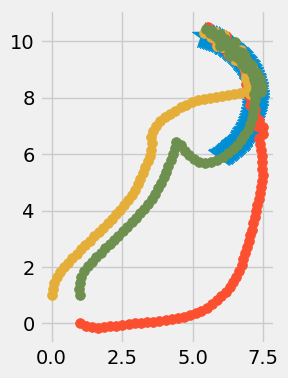

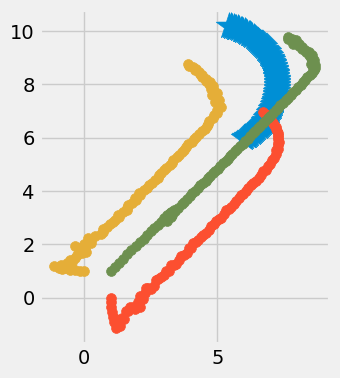

In [103]:
i=0
for log in logs:
    fig = plt.figure(dpi=100)

    if name=='-Tr(FIM)':
        continue
#     plot_all(log.export(),'','{}.png'.format(name))
    ax = plt.gca()
    plot_experiment(ax,log.export())
    i+=1
    
    fig.tight_layout()
    fig.savefig('{}.png'.format(name))
    plt.show()

